# Facial Recognition

## Dependencies

In [15]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer
import tensorflow as tf

## Constants

In [11]:
model_path = 'siamesemodel.h5'
anchor_path = 'current_faces'

## Load model

In [18]:
class CustomModel(Model):
    def train_step(self, batch):
        with tf.GradientTape() as tape:
            X = batch[:2]
            y = batch[2]

            yhat = self(X, training=True)
            loss = self.compiled_loss(y, yhat, regularization_losses=self.losses)
        print(loss)#we'll see about this

        # Calculate gradients
        grad = tape.gradient(loss, self.trainable_variables)

        # Calculate updated weights and apply to siamese model
        self.optimizer.apply_gradients(zip(grad, self.trainable_variables))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, yhat)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [19]:
verifier = load_model(model_path, custom_objects={'L1Dist':L1Dist, 'CustomModel': CustomModel})

In [20]:
verifier.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (CustomModel)        (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [21]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0

    return img

## Evaluate a person

1/1 [==============================] - 0s 294ms/step
kid
[[0.8828486]]


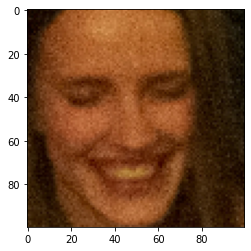

In [64]:
submitted_pic = preprocess('test3.jpg')#TODO file upload

max_similarity = 0
supposed_person = ""
treshold = 0.5

for person_folder in os.listdir(anchor_path):
    similarity = 0
    anchors_count = 0
    positives_count = 0
    
    for filename in os.listdir(os.path.join(anchor_path, person_folder)):
        validation_pic = preprocess(os.path.join(anchor_path, person_folder, filename))
        anchors_count = anchors_count + 1
        
        prediction = verifier.predict(list(np.expand_dims([submitted_pic, validation_pic], axis=1)))
        if prediction > treshold:
            similarity = similarity+prediction
            positives_count = positives_count + 1
            
    if positives_count>0:
        similarity = similarity/positives_count
        
    if similarity > max_similarity and similarity > treshold:
        max_similarity = similarity
        supposed_person=person_folder
        
print(supposed_person)
print(max_similarity)
plt.imshow(submitted_pic)
plt.show()